# Si.T.T. Basic Example

In this notebook, we will explore the basic features of Si.T.T. and show how to make the platform work on a basic level.

## Installing Si.T.T.

First, we need to integrate the Python library. Note, you need to install the required Python packages, first. A common way to do this is to use pip (search the Web for venv, Conda etc. for specific environments).

This is pretty straightforward (upgrade will ensure you have the latest version of Si.T.T. installed):

In [ ]:
!pip install --upgrade sitt

If you want to uninstall Si.T.T., you can do so by running the following command:

```console
pip uninstall -y sitt
```

## Basic Usage

After you have installed Si.T.T., you can import the library (we will also import a couple if other modules):

In [1]:
import sitt

## Configuration

In order to run a simulation, you need a configuration. The configuration defines all the variables, modules and simulation steps needed. For the sake of demonstration, we will create the configuration using Python.

In [3]:
config = sitt.Configuration()
print(config)

!!python/object:sitt.base.Configuration
break_simulation_after: 100
output: []
preparation: []
quiet: false
simulation_define_state: []
simulation_end: null
simulation_prepare_day: []
simulation_start: null
simulation_step: []
verbose: false



As you can see, the configuration is a simple Python object. There are three main components of the simulation:

* Preparation: prepare data
* Simulation: actual simulation
* Output: showing or saving data

You can read more on these components in the [Concept Readme](../readmes/concept.md).


## Preparation

For now, let us look at the first part, the preparation. We will skip the simulation and output steps, and import a serialized graph (containing an arbitrary set of hubs and roads in Southern Austria):

In [4]:
# Skip simulation (and output)
config.skip_step = sitt.SkipStep.SIMULATION

# we will also make the output verbose, so we can see what the application is doing in its log output.
config.verbose = True

# Create an import module for the preparation component and add it the preparation component
graph_load = sitt.preparation.GraphLoad(filename='example_graph.pkl')
config.preparation.append(graph_load)

To see what is in the graph, we can use another module:

In [5]:
preparation_debug = sitt.preparation.DebugDisplayRoadsAndHubs()
config.preparation.append(preparation_debug)

Now let us run the application (the preparation, that is) and see what the debug output will show us. The simulation can be run by creating a core object and running it:

2022-11-04 19:56:17,062 ******** Preparation: started ********
2022-11-04 19:56:17,063 Loading graph from: example_graph.pkl
2022-11-04 19:56:17,066 Displaying roads and hubs
2022-11-04 19:56:17,066 Drawing network.


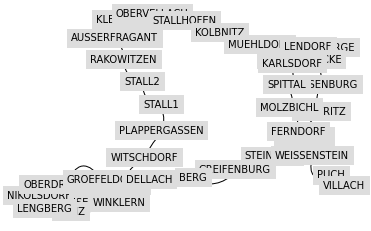

2022-11-04 19:56:19,652 ******** Preparation: finished ********


In [6]:
core = sitt.Core(config)
core.run()

You can see the network... kind of, the image is a bit too small, but you get a first impression. Now let us check the data a bit more thoroughly. What paths could we take from point A to point B and how would the roads look like?

No problem, let us update the debug and just output all possible paths between Lienz and Villach:

2022-11-04 19:56:22,541 ******** Preparation: started ********
2022-11-04 19:56:22,543 Loading graph from: example_graph.pkl
2022-11-04 19:56:22,546 Displaying roads and hubs
2022-11-04 19:56:22,548 Drawing 6 route(s) from LIENZ to VILLACH.


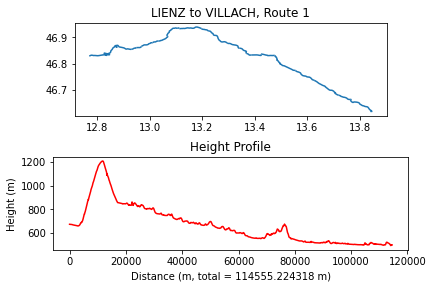

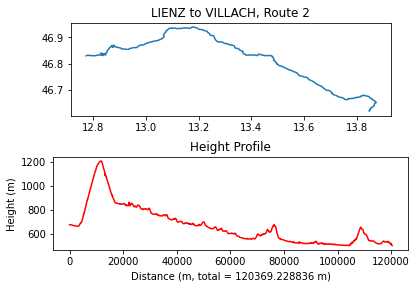

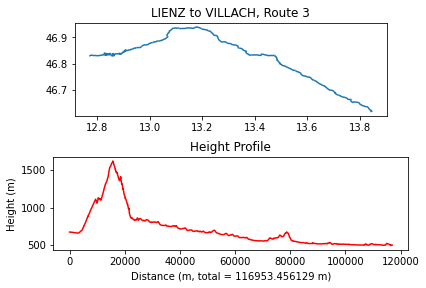

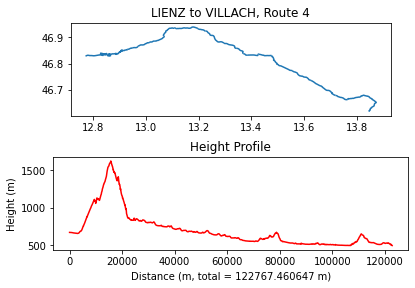

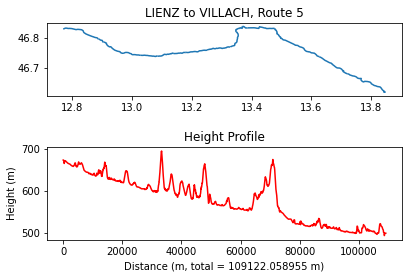

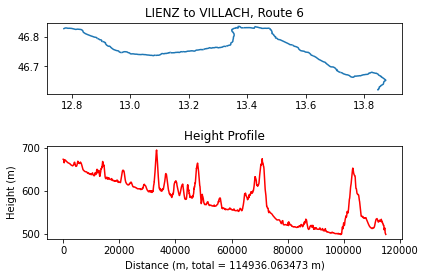

2022-11-04 19:56:24,239 ******** Preparation: finished ********


In [7]:
# turn off showing whole network
preparation_debug.draw_network = False

# set start and end points
preparation_debug.start = 'LIENZ'
preparation_debug.end = 'VILLACH'

core.run()

Wow, there six possible routes including height profiles. Time to start the simulation!

## A Simple Simulation

Now we want to actually run the simulation. Like above, we have to create a configuration first. In addition to the things shown above, we will add a preparation component to precalculate the possible routes used in the simulation.

In [14]:
# create new config
config = sitt.Configuration()

# Skip output
config.skip_step = sitt.SkipStep.OUTPUT

# we will also make the output verbose, so we can see what the application is doing in its log output.
config.verbose = True

# We want to tell our simulation where to start and end the simulation:
config.simulation_start = 'LIENZ'
config.simulation_end = 'VILLACH'

# Create an import module for the preparation component and add it the preparation component
graph_load = sitt.preparation.GraphLoad(filename='example_graph.pkl')
config.preparation.append(graph_load)

# Before we can run our simulation, we need to create all possible routes - here is a simple route creator
create_routes = sitt.preparation.CreateRoutes()
config.preparation.append(create_routes)

We will use a very simple simulation runner: An agent travelling 4 kph up to a maximum of 8 hours a day (so 32 km maximum which is a good average for a normal person on foot). The agent will slow a bit on slopes, we will use a linear factor to simulate this. Granted, this is not a very good simulation (some exponential function would be more precise), but for the sake of simplicity, it will do.

In [15]:
# This is the new part: Create a simple simulation stepper
simple_stepper = sitt.simulation_step.Simple(speed=4.0)
config.simulation_step.append(simple_stepper)

# Set start and end points of the simulation
config.simulation_start = 'LIENZ'
config.simulation_end = 'VILLACH'

# Run the core
core = sitt.Core(config)
core.run()

2022-11-04 19:58:09,888 ******** Preparation: started ********
2022-11-04 19:58:09,891 Loading graph from: example_graph.pkl
2022-11-04 19:58:09,899 PreparationInterface CreateRoutes: creating routes and checking lengths
2022-11-04 19:58:09,905 ******** Preparation: finished ********
2022-11-04 19:58:09,906 ******** Simulation: started ********
2022-11-04 19:58:09,907 start:  LIENZ
2022-11-04 19:58:09,908 end:    VILLACH
2022-11-04 19:58:09,909 routes: MultiDiGraph with 36 nodes and 38 edges
2022-11-04 19:58:09,910 Running day 1 with 2 active agent(s).
2022-11-04 19:58:09,917 Running day 2 with 2 active agent(s).
2022-11-04 19:58:09,926 Running day 3 with 2 active agent(s).
2022-11-04 19:58:09,936 Running day 4 with 2 active agent(s).
2022-11-04 19:58:09,943 Running day 5 with 1 active agent(s).
2022-11-04 19:58:09,946 ******** Simulation: finished ********


As you can experiment a bit, changing values or reversing the order of the simulation start and end. If you change the values too much, you might end up with paths that are cancelled due to the agent not being able to traverse this particular path.

It is also possible to chain steppers. This does not make sense with the simple stepper, but there are use cases where environmental changes might change travel times, and you want to make this modular.

## Simulation Output

The last step showed you how to run a basic simulation. We are still missing some output we can analyze. This can be done by adding output modules. Like preparation and simulation modules, you can chain output modules to create multiple outputs at once.

We will expand our simple simulation and add a JSON output module:

In [4]:
# create new config
config = sitt.Configuration()

# We will make out application quiet this time, we do not need any debug output.
config.quiet = True

# We want to tell our simulation where to start and end the simulation:
config.simulation_start = 'LIENZ'
config.simulation_end = 'VILLACH'

# Create an import module for the preparation component and add it the preparation component
graph_load = sitt.preparation.GraphLoad(filename='example_graph.pkl')
config.preparation.append(graph_load)

# Before we can run our simulation, we need to create all possible routes - here is a simple route creator
create_routes = sitt.preparation.CreateRoutes()
config.preparation.append(create_routes)

# Create a simple simulation stepper
simple_stepper = sitt.simulation_step.Simple(speed=4.0)
config.simulation_step.append(simple_stepper)

# New: Add the JSON output module - do not convert output data to string, leave it as it is
json_output = sitt.output.JSONOutput(to_string=False)
config.output.append(json_output)

# Set start and end points of the simulation
config.simulation_start = 'LIENZ'
config.simulation_end = 'VILLACH'

# Run the core
core = sitt.Core(config)
outputs = core.run()

print(len(outputs))

1


As we can see, `core.run()` has a return value: A list of outputs, equal to the number of output modules defined in the configuration. So our output will be in `outputs[0]`. It is quite longish, so we will check the keys first:

In [7]:
outputs[0].keys()

dict_keys(['simulation_start', 'simulation_end', 'agents_finished', 'agents_cancelled', 'legs', 'nodes', 'paths'])

In [11]:
outputs[0]['agents_finished']

[{'uid': 'OIBR7uemc6C5',
  'uids': ['OIBR7uemc6C5',
   '3zNXP3EEnZvT',
   'uAcz7cqY6fda',
   'uL5NKdVABEG2',
   'ynqwSHaLzEWT'],
  'status': 'finished',
  'day': 5,
  'hour': 11.499848697791732},
 {'uid': 'JTxXpwY7w3ED',
  'uids': ['JTxXpwY7w3ED',
   '3zNXP3EEnZvT',
   'uAcz7cqY6fda',
   'uL5NKdVABEG2',
   'ynqwSHaLzEWT'],
  'status': 'finished',
  'day': 5,
  'hour': 13.09813788939288}]

We see we have a total of two different agents that have finished, both on day 5. The uids show the legs of the journey, so we can see that they do not differ too much.